##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Semantic Segmentation with Model Garden

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tfmodels/vision/semantic_segmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/docs/vision/semantic_segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/docs/vision/semantic_segmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/docs/vision/semantic_segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a [DeepLabV3](https://arxiv.org/pdf/1706.05587.pdf) with [Mobilenet V2](https://arxiv.org/abs/1801.04381) as backbone model from the [TensorFlow Model Garden](https://pypi.org/project/tf-models-official/) package (tensorflow-models).


[Model Garden](https://www.tensorflow.org/tfmodels) contains a collection of state-of-the-art models, implemented with TensorFlow's high-level APIs. The implementations demonstrate the best practices for modeling, letting users to take full advantage of TensorFlow for their research and product development.

**Dataset**: [Oxford-IIIT Pets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)

* The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed.


**This tutorial demonstrates how to:**

1. Use models from the TensorFlow Models package.
2. Train/Fine-tune a pre-built DeepLabV3 with mobilenet as backbone for Semantic Segmentation.
3. Export the trained/tuned DeepLabV3 model

## Install necessary dependencies

In [ ]:
!pip install -U -q "tensorflow>=2.9.2" "tf-models-official"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 71.6 MB/s eta 0:00:00


## Import required libraries

In [ ]:
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds


import orbit
import tensorflow_models as tfm
from official.vision.data import tfrecord_lib
from official.vision.serving import export_saved_model_lib
from official.vision.utils.object_detection import visualization_utils

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.14.0


## Custom dataset preparation for semantic segmentation
Models in Official repository (of model-garden) require models in a TFRecords dataformat.

Please check [this resource](https://www.tensorflow.org/tutorials/load_data/tfrecord) to learn more about TFRecords data format.

[Oxford_IIIT_pet:3](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet) dataset is taken from [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)

In [ ]:
(train_ds, val_ds, test_ds), info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    split=['train+test[:50%]', 'test[50%:80%]', 'test[80%:100%]'],
    with_info=True)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteV6338L/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteV6338L/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpidguem_xtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

### Helper function to encode dataset as tfrecords

In [ ]:
def process_record(record):
  keys_to_features = {
  'image/encoded': tfrecord_lib.convert_to_feature(
      tf.io.encode_jpeg(record['image']).numpy()),
  'image/height': tfrecord_lib.convert_to_feature(record['image'].shape[0]),
  'image/width': tfrecord_lib.convert_to_feature(record['image'].shape[1]),
  'image/segmentation/class/encoded':tfrecord_lib.convert_to_feature(
      tf.io.encode_png(record['segmentation_mask'] - 1).numpy())
  }
  example = tf.train.Example(
      features=tf.train.Features(feature=keys_to_features))
  return example

### Write TFRecords to a folder

In [ ]:
output_dir = './oxford_iiit_pet_tfrecords/'
LOG_EVERY = 100
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

def write_tfrecords(dataset, output_path, num_shards=1):
  writers = [
        tf.io.TFRecordWriter(
            output_path + '-%05d-of-%05d.tfrecord' % (i, num_shards))
        for i in range(num_shards)
    ]
  for idx, record in enumerate(dataset):
    if idx % LOG_EVERY == 0:
      print('On image %d', idx)
    tf_example = process_record(record)
    writers[idx % num_shards].write(tf_example.SerializeToString())

### Write training data as TFRecords

In [ ]:
output_train_tfrecs = output_dir + 'train'
write_tfrecords(train_ds, output_train_tfrecs, num_shards=10)

On image %d 0
On image %d 100
On image %d 200
On image %d 300
On image %d 400
On image %d 500
On image %d 600
On image %d 700
On image %d 800
On image %d 900
On image %d 1000
On image %d 1100
On image %d 1200
On image %d 1300
On image %d 1400
On image %d 1500
On image %d 1600
On image %d 1700
On image %d 1800
On image %d 1900
On image %d 2000
On image %d 2100
On image %d 2200
On image %d 2300
On image %d 2400
On image %d 2500
On image %d 2600
On image %d 2700
On image %d 2800
On image %d 2900
On image %d 3000
On image %d 3100
On image %d 3200
On image %d 3300
On image %d 3400
On image %d 3500
On image %d 3600
On image %d 3700
On image %d 3800
On image %d 3900
On image %d 4000
On image %d 4100
On image %d 4200
On image %d 4300
On image %d 4400
On image %d 4500
On image %d 4600
On image %d 4700
On image %d 4800
On image %d 4900
On image %d 5000
On image %d 5100
On image %d 5200
On image %d 5300
On image %d 5400
On image %d 5500


### Write validation data as TFRecords

In [ ]:
output_val_tfrecs = output_dir + 'val'
write_tfrecords(val_ds, output_val_tfrecs, num_shards=5)

On image %d 0
On image %d 100
On image %d 200
On image %d 300
On image %d 400
On image %d 500
On image %d 600
On image %d 700
On image %d 800
On image %d 900
On image %d 1000
On image %d 1100


### Write test data as TFRecords

In [ ]:
output_test_tfrecs = output_dir + 'test'
write_tfrecords(test_ds, output_test_tfrecs, num_shards=5)

On image %d 0
On image %d 100
On image %d 200
On image %d 300
On image %d 400
On image %d 500
On image %d 600
On image %d 700


## Configure the DeepLabV3 Mobilenet model for custom dataset

In [ ]:
train_data_tfrecords = './oxford_iiit_pet_tfrecords/train*'
val_data_tfrecords = './oxford_iiit_pet_tfrecords/val*'
test_data_tfrecords = './oxford_iiit_pet_tfrecords/test*'
trained_model = './trained_model/'
export_dir = './exported_model/'

In Model Garden, the collections of parameters that define a model are called *configs*. Model Garden can create a config based on a known set of parameters via a [factory](https://en.wikipedia.org/wiki/Factory_method_pattern).


Use the `mnv2_deeplabv3_pascal` experiment configuration, as defined by `tfm.vision.configs.semantic_segmentation.mnv2_deeplabv3_pascal`.

Please find all the registered experiements [here](https://www.tensorflow.org/api_docs/python/tfm/core/exp_factory/get_exp_config)

The configuration defines an experiment to train a [DeepLabV3](https://arxiv.org/pdf/1706.05587.pdf) model with MobilenetV2 as backbone and [ASPP](https://arxiv.org/pdf/1606.00915v2.pdf) as decoder.

There are also other alternative experiments available such as

* `seg_deeplabv3_pascal`
* `seg_deeplabv3plus_pascal`
* `seg_resnetfpn_pascal`
* `mnv2_deeplabv3plus_cityscapes`

and more. One can switch to them by changing the experiment name argument to the `get_exp_config` function.


In [ ]:
exp_config = tfm.core.exp_factory.get_exp_config('mnv2_deeplabv3_pascal')

In [ ]:
model_ckpt_path = './model_ckpt/'
if not os.path.exists(model_ckpt_path):
  os.mkdir(model_ckpt_path)

!gsutil cp gs://tf_model_garden/cloud/vision-2.0/deeplab/deeplabv3_mobilenetv2_coco/best_ckpt-63.data-00000-of-00001 './model_ckpt/'
!gsutil cp gs://tf_model_garden/cloud/vision-2.0/deeplab/deeplabv3_mobilenetv2_coco/best_ckpt-63.index './model_ckpt/'

Copying gs://tf_model_garden/cloud/vision-2.0/deeplab/deeplabv3_mobilenetv2_coco/best_ckpt-63.data-00000-of-00001...
- [1 files][ 28.2 MiB/ 28.2 MiB]                                                
Operation completed over 1 objects/28.2 MiB.                                     
Copying gs://tf_model_garden/cloud/vision-2.0/deeplab/deeplabv3_mobilenetv2_coco/best_ckpt-63.index...
/ [1 files][ 12.5 KiB/ 12.5 KiB]                                                
Operation completed over 1 objects/12.5 KiB.                                     


### Adjust the model and dataset configurations so that it works with custom dataset.

In [ ]:
num_classes = 3
WIDTH, HEIGHT = 128, 128
input_size = [HEIGHT, WIDTH, 3]
BATCH_SIZE = 16

# Backbone Config
exp_config.task.init_checkpoint = model_ckpt_path + 'best_ckpt-63'
exp_config.task.freeze_backbone = True

# Model Config
exp_config.task.model.num_classes = num_classes
exp_config.task.model.input_size = input_size

# Training Data Config
exp_config.task.train_data.aug_scale_min = 1.0
exp_config.task.train_data.aug_scale_max = 1.0
exp_config.task.train_data.input_path = train_data_tfrecords
exp_config.task.train_data.global_batch_size = BATCH_SIZE
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.output_size = [HEIGHT, WIDTH]
exp_config.task.train_data.preserve_aspect_ratio = False
exp_config.task.train_data.seed = 21 # Reproducable Training Data

# Validation Data Config
exp_config.task.validation_data.input_path = val_data_tfrecords
exp_config.task.validation_data.global_batch_size = BATCH_SIZE
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.output_size = [HEIGHT, WIDTH]
exp_config.task.validation_data.preserve_aspect_ratio = False
exp_config.task.validation_data.groundtruth_padded_size = [HEIGHT, WIDTH]
exp_config.task.validation_data.seed = 21 # Reproducable Validation Data

### Adjust the trainer configuration.

In [ ]:
logical_device_names = [logical_device.name
                        for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 2000
exp_config.trainer.steps_per_loop = int(train_ds.__len__().numpy() // BATCH_SIZE)

exp_config.trainer.summary_interval = exp_config.trainer.steps_per_loop # steps_per_loop = num_of_validation_examples // eval_batch_size
exp_config.trainer.checkpoint_interval = exp_config.trainer.steps_per_loop
exp_config.trainer.validation_interval = exp_config.trainer.steps_per_loop
exp_config.trainer.validation_steps =  int(train_ds.__len__().numpy() // BATCH_SIZE) # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = exp_config.trainer.steps_per_loop
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

This may be broken in Colab.


### Print the modified configuration.

In [ ]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': None,
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'use_tpu_mp_strategy': False,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'differential_privacy_config': None,
                'eval_input_partition_dims': [],
 

<IPython.core.display.Javascript object>

### Set up the distribution strategy.

In [ ]:
# Setting up the Strategy
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print("Done")

Done


## Create the `Task` object (`tfm.core.base_task.Task`) from the `config_definitions.TaskConfig`.

The `Task` object has all the methods necessary for building the dataset, building the model, and running training & evaluation. These methods are driven by `tfm.core.train_lib.run_experiment`.

In [ ]:
model_dir = './trained_model/'

with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

## Visualize a batch of the data.

In [ ]:
for images, masks in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'masks.shape: {str(masks["masks"].shape):16} images.dtype: {masks["masks"].dtype!r}')


images.shape: (16, 128, 128, 3)  images.dtype: tf.float32
masks.shape: (16, 128, 128, 1) images.dtype: tf.float32


### Helper function for visualizing the results from TFRecords

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))


    plt.axis('off')
  plt.show()

### Visualization of training data

Image Title represents what is depicted from the image.

Same helper function can be used while visualizing predicted mask

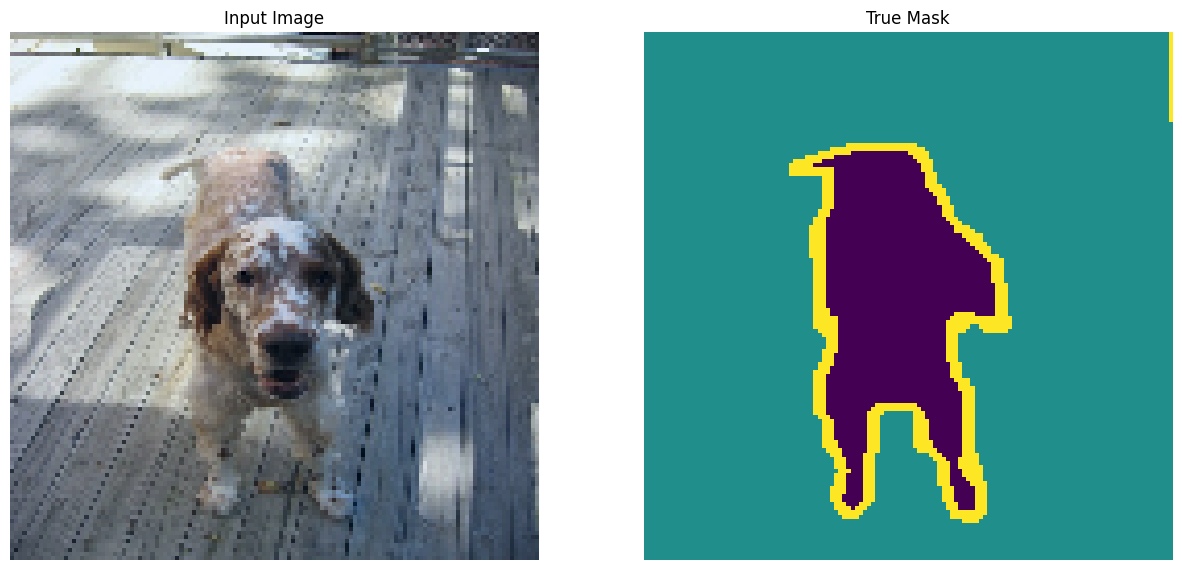

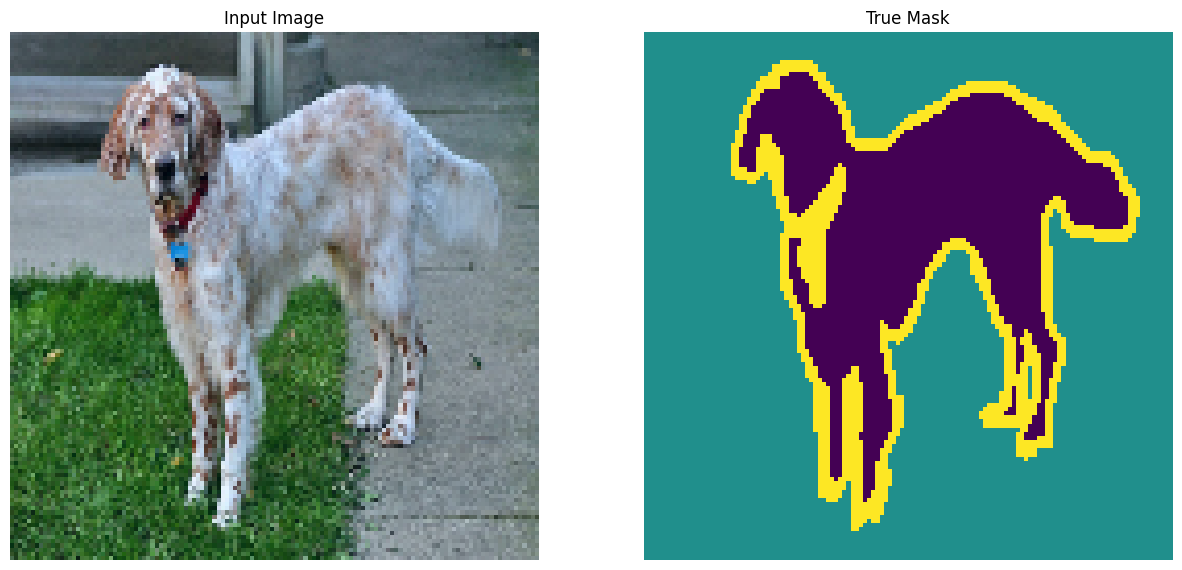

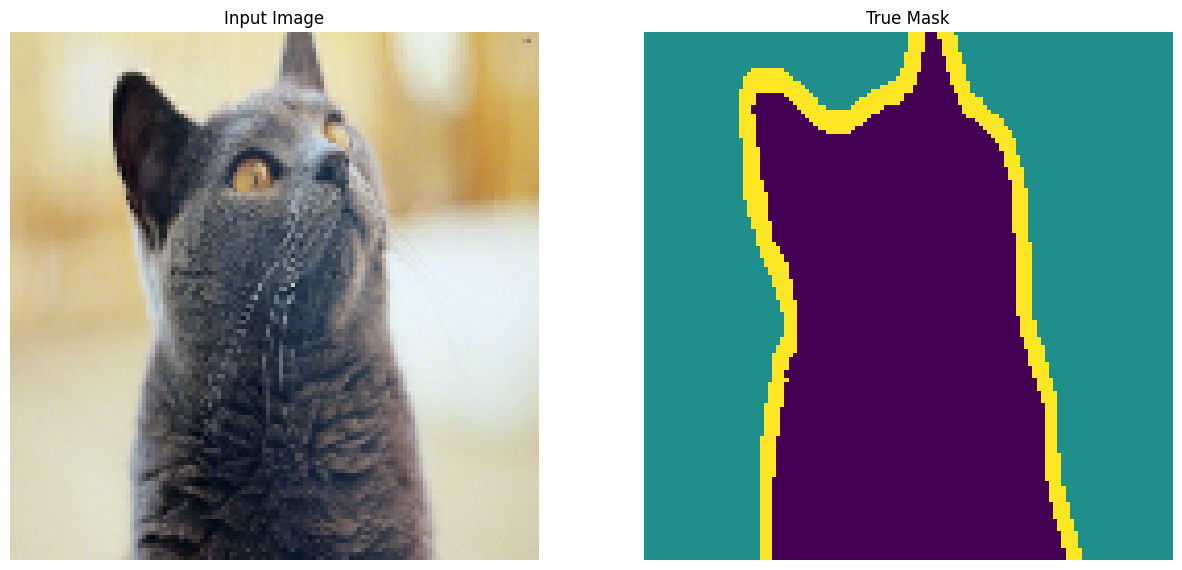

In [ ]:
num_examples = 3

for images, masks in task.build_inputs(exp_config.task.train_data).take(num_examples):
  display([images[0], masks['masks'][0]])

## Train and evaluate
**IoU**: is defined as the area of the intersection divided by the area of the union of a predicted mask and ground truth mask.

In [ ]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...
train | step:      0 | training until step 344...


train | step:    344 | steps/sec:    4.1 | output: 
    {'learning_rate': 0.09287634,
     'mean_iou': 0.57807887,
     'training_loss': 0.4984186}
saved checkpoint to ./trained_model/ckpt-344.
 eval | step:    344 | running 344 steps of evaluation...


Instructions for updating:
Use `tf.linalg.matmul` instead


 eval | step:    344 | steps/sec:   17.9 | eval time:   19.2 sec | output: 
    {'best_mean_iou': 0.6197178,
     'iou/0': 0.68024164,
     'iou/1': 0.8372499,
     'iou/2': 0.3416617,
     'mean_iou': 0.6197178,
     'steps_per_second': 17.927472218728692,
     'validation_loss': 0.0}
train | step:    344 | training until step 688...
train | step:    688 | steps/sec:    5.2 | output: {'learning_rate': 0.0735352, 'mean_iou': 0.6414453, 'training_loss': 0.416007}
saved checkpoint to ./trained_model/ckpt-688.
 eval | step:    688 | running 344 steps of evaluation...
 eval | step:    688 | steps/sec:   27.3 | eval time:   12.6 sec | output: 
    {'best_mean_iou': 0.6652424,
     'iou/0': 0.77816814,
     'iou/1': 0.87549603,
     'iou/2': 0.34206292,
     'mean_iou': 0.6652424,
     'steps_per_second': 27.324918651565685,
     'validation_loss': 0.0}
train | step:    688 | training until step 1032...
train | step:   1032 | steps/sec:    5.6 | output: 
    {'learning_rate': 0.047487784,
  

## Load logs in tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './trained_model'

<IPython.core.display.Javascript object>

## Saving and exporting the trained model

The `keras.Model` object returned by `train_lib.run_experiment` expects the data to be normalized by the dataset loader using the same mean and variance statiscics in `preprocess_ops.normalize_image(image, offset=MEAN_RGB, scale=STDDEV_RGB)`. This export function handles those details, so you can pass `tf.uint8` images and get the correct results.

In [ ]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

## Importing SavedModel

In [ ]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

## Visualize predictions

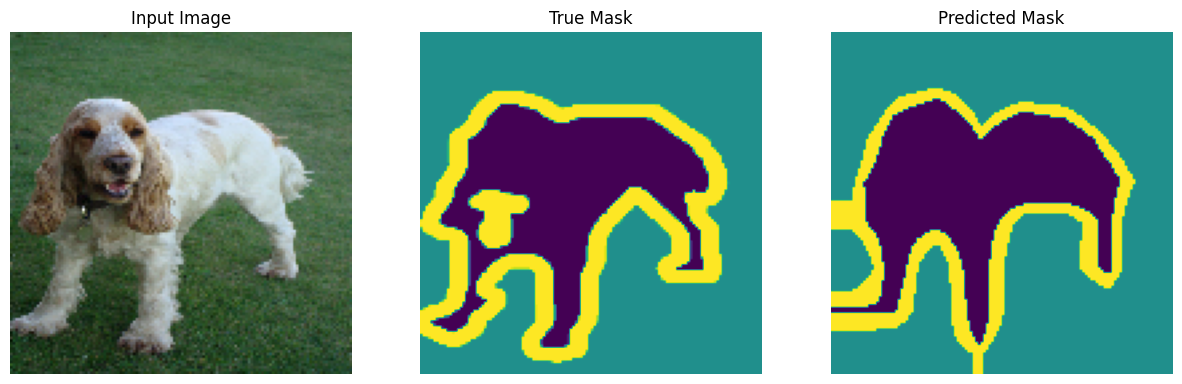

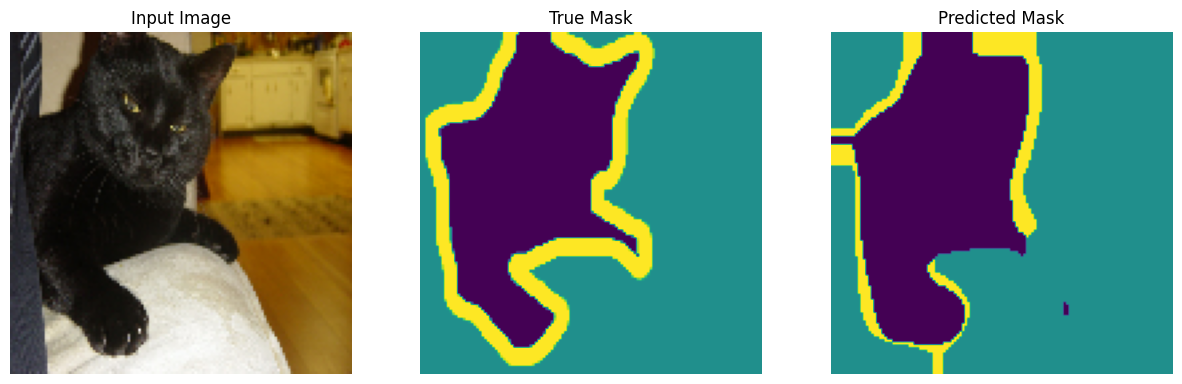

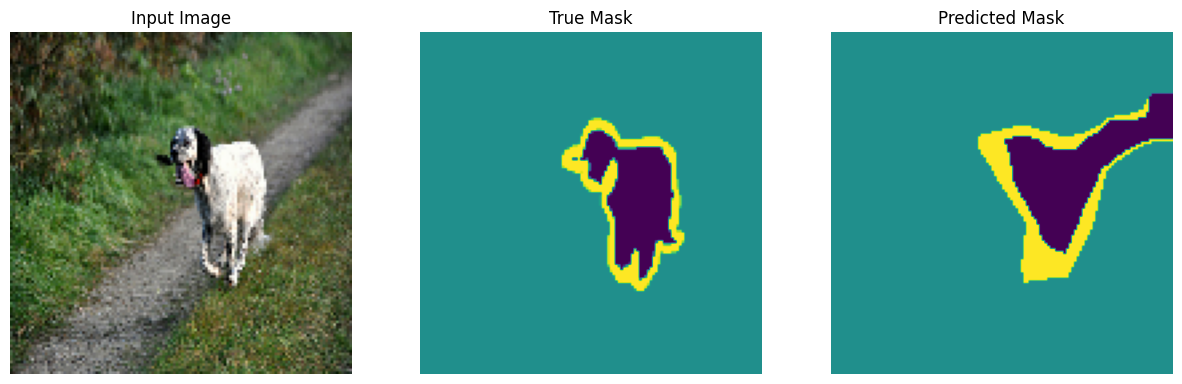

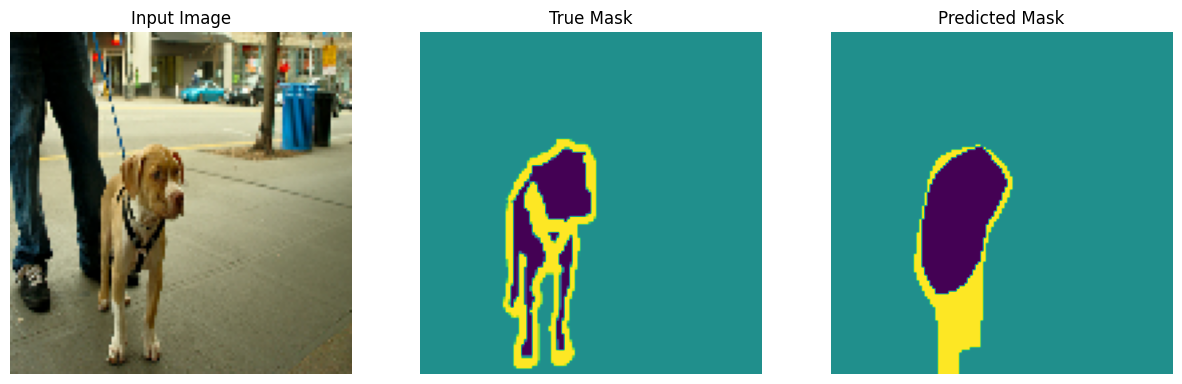

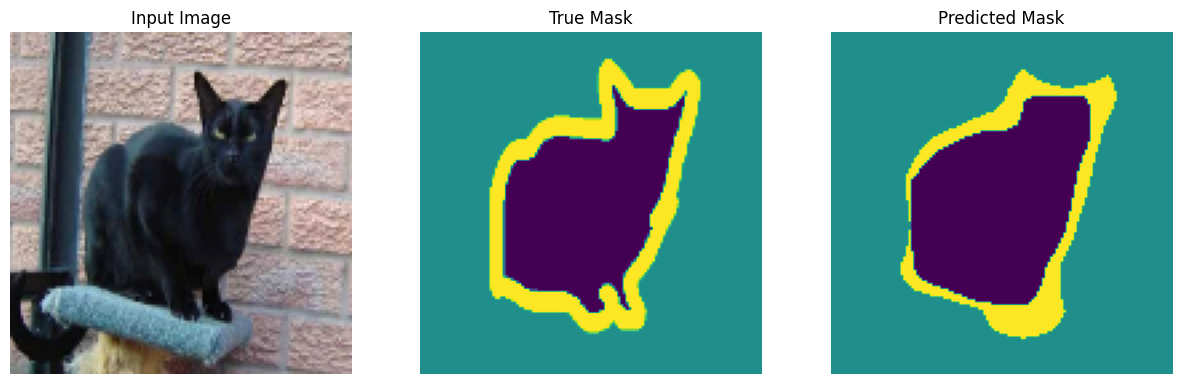

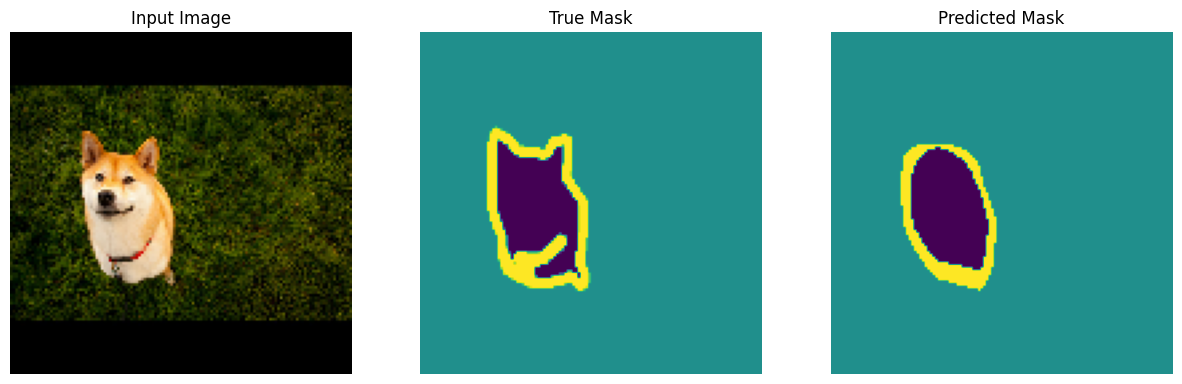

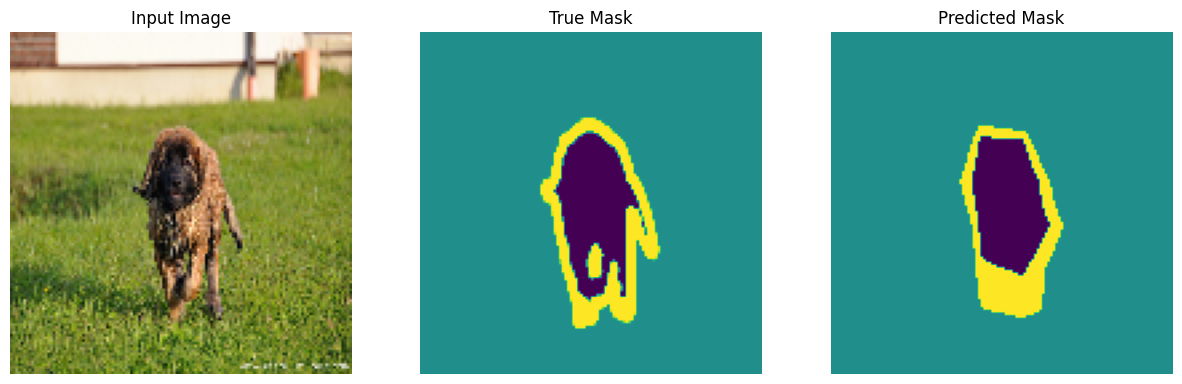

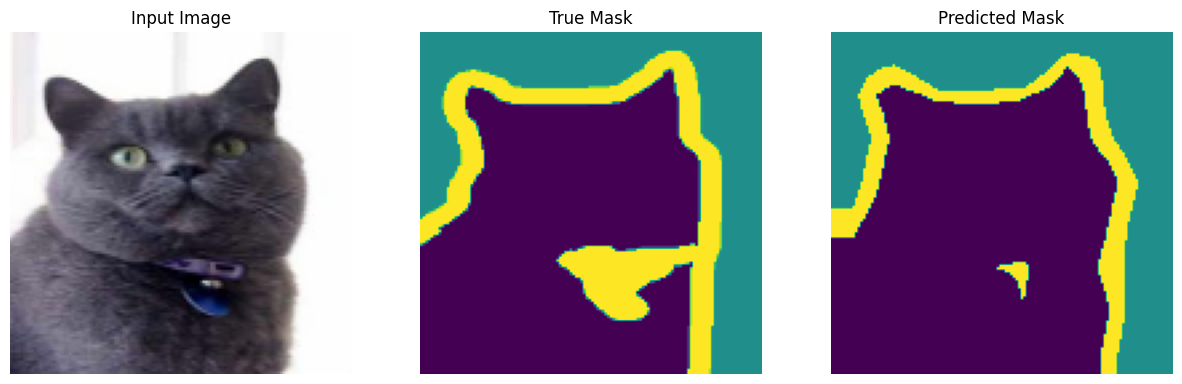

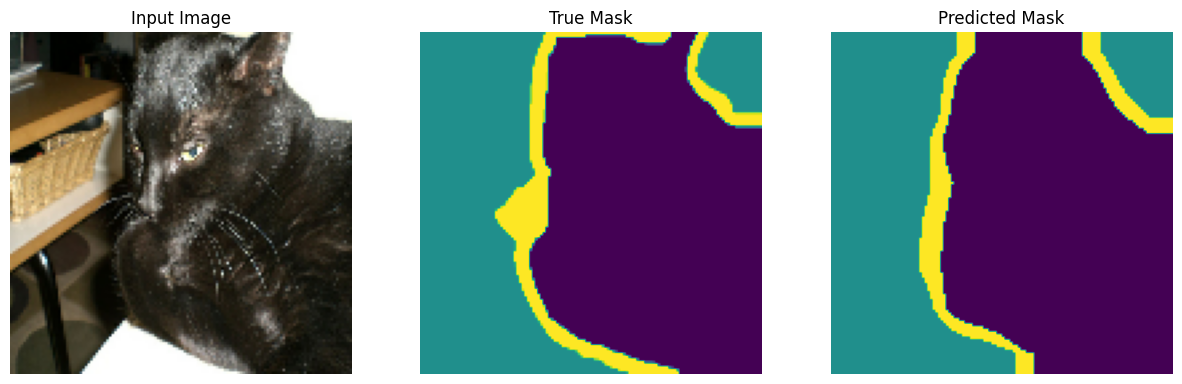

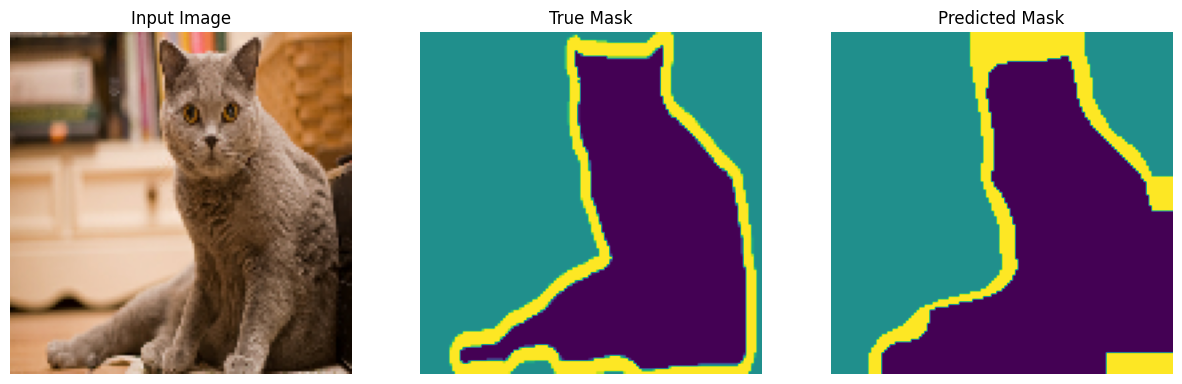

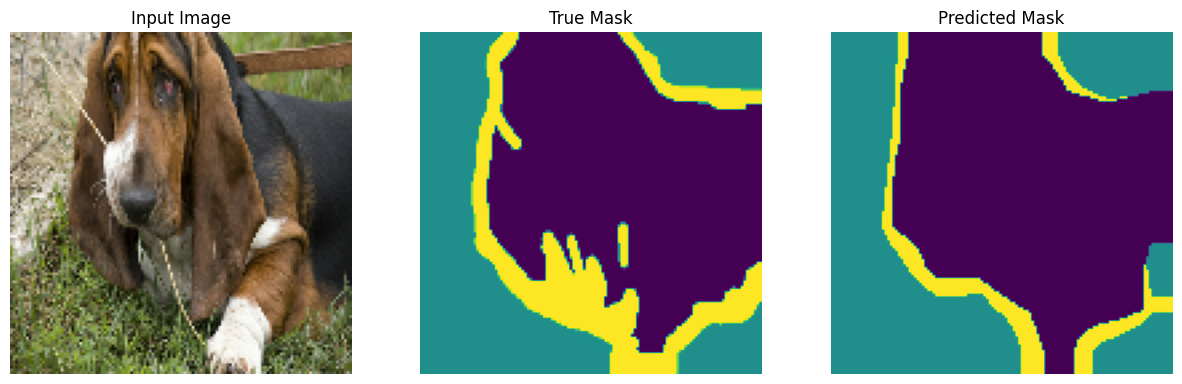

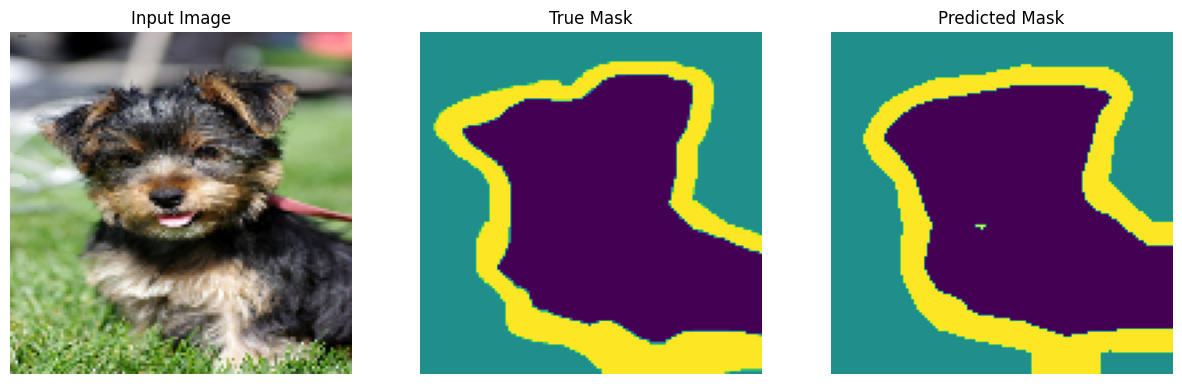

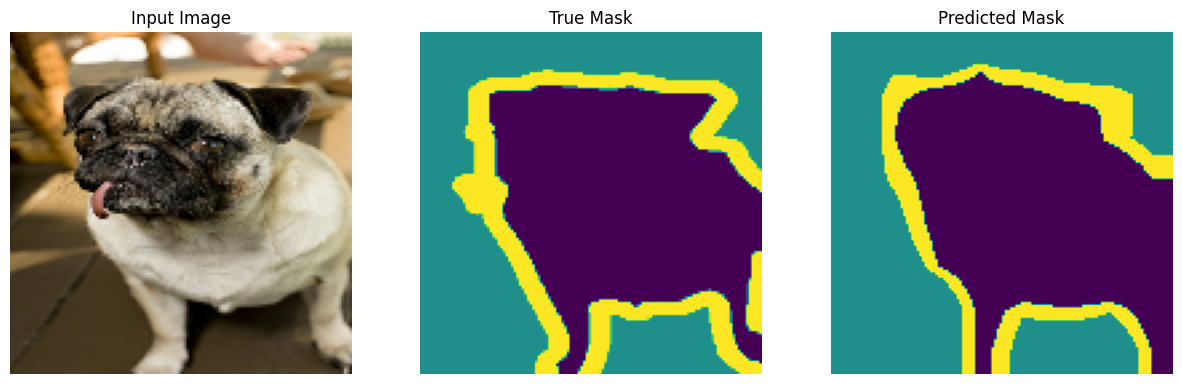

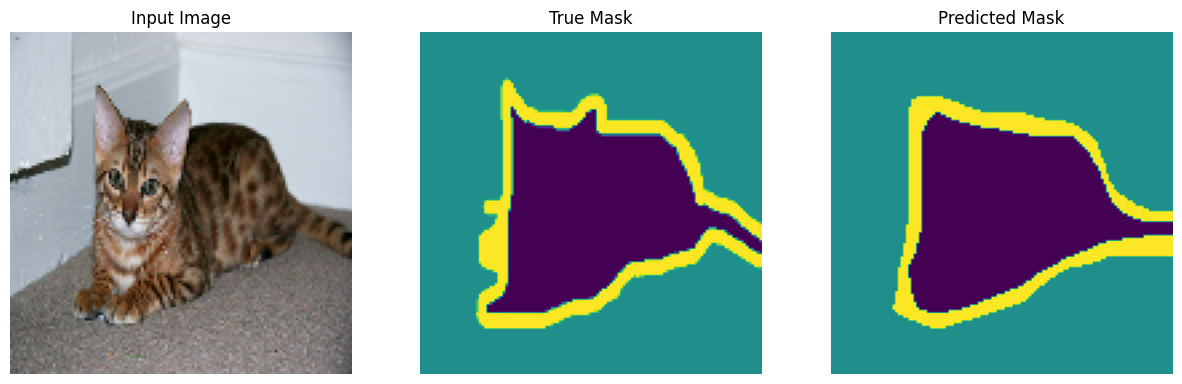

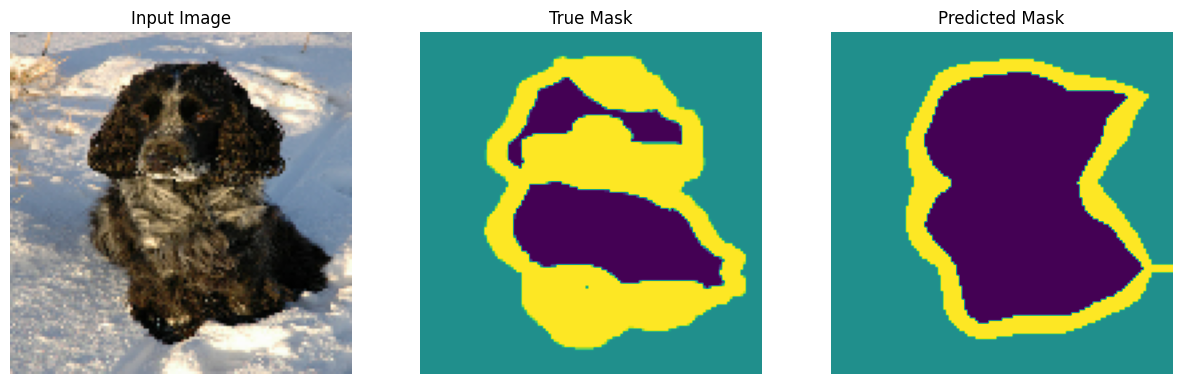

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


for record in test_ds.take(15):
  image = tf.image.resize(record['image'], size=[HEIGHT, WIDTH])
  image = tf.cast(image, dtype=tf.uint8)
  mask = tf.image.resize(record['segmentation_mask'], size=[HEIGHT, WIDTH])
  predicted_mask = model_fn(tf.expand_dims(record['image'], axis=0))
  display([image, mask, create_mask(predicted_mask['logits'])])